*24 Dec 2024, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import copy
from scipy import stats, interpolate, signal
import pandas as pd
from datetime import datetime, timedelta

# pull files from the internet if needed (e.g. temporary session in Colab)
# !wget https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/main/Tobermory_20160430_20161231.csv

---------------------------

# 08: Data interpolation/extrapolation

Sometimes data is not collocated exactly where we want it, or data is simply missing, or a bit weird looking, like the example below:

<img src="https://i.imgur.com/UpcdmZP.jpg" width="400" alt='discontinuity'>

Jokes aside, the observation stations taking data might not be exactly where you want it, or the machine broke for some of the observation period. Some choice needs to be taken in these scenarios when computing statistics or the like: usually, we either blank out missing data, or we fill out the location with some sensible data given information from other data points. We focus mostly on the latter here, although we do some recap on the former first using data we have already encountered.

> NOTE: The discussion below focuses on the time variable, but the discussion applies equally well to space variables; we will revisit some of the tools here in *10_fun_with_maps*.

# a) Blanking out data

Below I am going to artificially create some data as in `03_regression` (I literally copy and pasted the code from there), but I am going to **mask** out some data. Note I am not removing the data, but labelling some data as something else: this could be missing data because of instrument breakdown, or bad data identified by some data cleaning algorithm or instrument faliure, whatever.

In [2]:
# artifically creating some data and modify some of those

seed = np.random.seed(69)

# just going to draw the line y = t, but randomly add some numbers to the noise because why not
n = 51
t = np.linspace(0, 10, n)
data_init  = np.linspace(0, 10, n)  # straight line, then add some noise to it (cf. workbook 03)
noise = 2.0 * (np.random.rand(n) - 0.5)
data_init += noise

# randomly generate some indices and modify the data at those indices
ind = np.random.randint(0, n, size=15)
data_init[ind] = -99.99

print(f"data array is:")
print(data_init)

data array is:
[-99.99       -99.99         0.10050505   1.17881851   0.92269795
 -99.99       -99.99       -99.99         1.94658476 -99.99
   2.46556641   2.77574812 -99.99         2.23536119   3.28204655
   2.65698846   3.14029097   2.76217144   3.2470088    3.70981231
   4.05926103   3.7860611    3.9539503    4.95630614   4.2669174
 -99.99         5.064665     5.17533257   5.27089241 -99.99
   6.97538223   6.26182874   6.76087232   6.38226947   6.03311239
 -99.99         7.02723219 -99.99         7.26390507   6.98743049
   7.91543339   8.81158582   7.78701842   8.53005698   8.18183504
   8.15176333   8.26397542 -99.99         9.11418404   8.93874754
  10.85437888]


The `-99.99` is a choice of the **mask value**, denoting **masked** data for possible reasons stated above (the choice of `-99.99` follows the El-Nino data you have seen before in the months where there was no data). 

Every dataset might do this slightly differently, so it is important to have a look and see what is going on before you decide on a strategy or method to do something about such data.

In this case, if nothing is done and we just do a plot, we get the following:

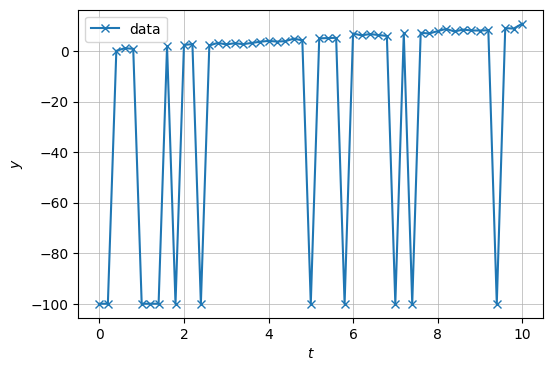

In [3]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(t, data_init, "x-", label = f"data")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

The values of `-99.99` are showing up in the plotting, which is a bit of a nuisance. For the purposes of plotting, one way to by pass the problem is simply to set the mask value to be `NaN` (Not a Number), by identifying the relevant indices and modifying the data array accordingly. The way I've done it below is just one way; there are multiple equivalent/better ways to do it.

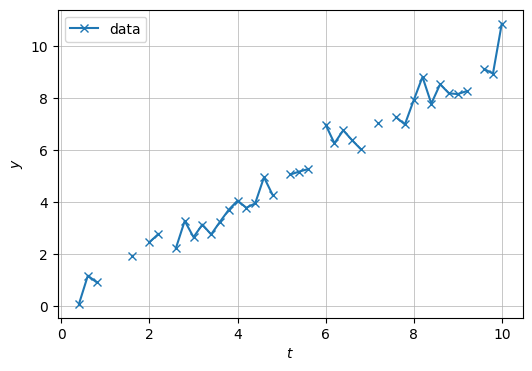

In [4]:
# make a separate copy of data_init and set the masked values to nans

data_mod = np.zeros(len(data_init))
data_mod[:] = data_init[:]              # does a copy of the array (avoid soft copying)
data_mod[data_init == -99.99] = np.nan  # set relevant entries to nan

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(t, data_mod, "x-", label = f"data")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

`NaN`s basically get ignored by the plot routine in this case. Some other routines such as `np.nanmean` and `np.nansum` can be called on the modified data for doing calculations (cf. workbook 01 and 02).
* if you do e.g. `np.sum(data_init)` it will take into account the masked values, which will give you an answer, but not necessarily the one you are looking for
* if you do e.g. `np.sum(data_mod)` then it will probably either crash and complain there are things you can sum over (because `NaN` is not a number so cannot be summed), or give you `nan` (my Python gives the latter, though I was 50% sure it used to crash in older versions of Python)
* if you do e.g. `np.nansum(data_mod)` it will give you probably what you are looking for

In [5]:
# example of doing elementary calculation on array with NaNs

print(f"      wrong calculation with the masked values: np.sum   (data_init) = {np.sum(data_init)}")
print(f"still wrong calculation with the masked values: np.nansum(data_init) = {np.nansum(data_init)}")
print(f"      ok(?) calculation with     nan'ed values: np.nansum(data_mod ) = {np.nansum(data_mod)}")
print(" ")
print(f"np.sum(data_mod) will return a nan; try it yourself below if you want")
#np.sum(data_mod)

      wrong calculation with the masked values: np.sum   (data_init) = -992.6820017615253
still wrong calculation with the masked values: np.nansum(data_init) = -992.6820017615253
      ok(?) calculation with     nan'ed values: np.nansum(data_mod ) = 207.19799823847467
 
np.sum(data_mod) will return a nan; try it yourself below if you want


Some other routines seem to not like seeing `nan`s, and will just crash (e.g. `np.polyfit` as one way to do polynomial regression). Others will let it pass by generate `nan` results if the array includes `nan`s (e.g. `scipy.stats.linregress`). The interpolation routines I've tested to be used later (in `scipy.interpolate`) seem to do a half-way house and gives `nan`s sometimes and not others...

The upshot is that we should probably learn how to pick out the locations of `nan`s and to make sure we ***don't*** pass that on to the relevant routines. One way to do it below is as follows (see the comment for the logic behind the routines. I'm going to do this with `scipy.stats.linregress`.

Text(0.5, 1.0, 'regressed $r$ value = 0.98')

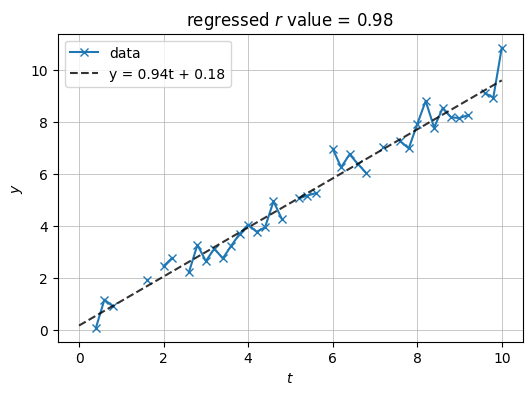

In [6]:
# do not throw in the nans in the calculations

# 1) indentify where nans are: "np.isnan" gives an array of true or false
# 2) flip the True and False with "~" (the NOT logic operator, with True <-> False)
# 3) subselect all the "Trues" from the arrays (so the NOT nans)
# 4) throw only those in to the relevant routines

y = data_mod[~np.isnan(data_mod)]
x = t[~np.isnan(data_mod)]             # need to select the correct values for linear regression
p = stats.linregress(x, y=y)
lin_model = p.slope * t + p.intercept  # linear regression model

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(t, data_mod, "x-", label = f"data")
ax.plot(t, lin_model, "k--", alpha = 0.8, label = f"y = {p.slope:.2f}t + {p.intercept:.2f}")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()
ax.set_title(f"regressed $r$ value = {p.rvalue:.2f}")

> <span style="color:red">**Q.**</span> Try using `np.polyfit` as in `03_regression` instead to generate a similar graph (you can use `np.polyval` to do the model evaluations if you want).

> <span style="color:red">**Q.**</span> Try using `np.polyfit` and `scipy.stats.linregress` as in `03_regression` to see how the regression routine fails if you apply it raw on `data_mod` with the `nan` entries (they fail in slightly different ways).

Make sure to understand the logic behind how to ignore masked data, because this will come back later in `10_fun_with_maps` where we deal with spatial data (and masked points might be points corresponding to physical land that we don't care about when dealing with the marine data).

# b) Interpolating (and extrapolating)

**Interpolation** can refer to generating data points using existing data points between existing points, while **extrapolation** would be generating data points using existing data points but outside of data point range. Two simple cases might be

* `2, 4, 6, 8, x, 12, 14` would be interpolation for `x` (`x=10` presumably)
* `1, 1, 3, 5, 8, 13, x` would be extrapolation for `x` (`x=21` presumably)

Going to mostly focus on interpolation here, only because the extrapolation is a bit more scientifically subtle and potentially dubious. There are several reasons one might want to do interpolation, as mentioned above:

* we have masked data as above, and we might want to interpolate for data at those points
* the data is not spaced in the way we want it (e.g. from uneven spacing to even spacing or vice-versa)
* we want higher resolution data for whatever reason

Whatever the reason, the thing to bear in mind is that the computer does not care about your reason for doing the interpolation: it only does the calculations and returns the numbers. You have to decide whether it is in fact scientifically meaningful to do the interpolation/extrapolation or use the relevant algorithms to give you those numbers. For example, suppose our data is sea surface height measurements at the coast at every two days for whatever reason, then

* masked points could correspond to land points in space, and there is no sea surface height over land
* interpolation to shift everything by a day simply means you replace actual measurements with guessed measurements, which seems to be a step down
* you can interpolate and refine as much as you like, but you are still not going to recover the semi-diurnal (every 12 hour) tide signal if the base data only measures things every 48 hours

## nearest neighbour and linear interpolation

The simplest case that we probably won't use that much is **nearest neighbour** interpolation. This simply means that, for a location $t_1$ of your choice between $t_0$ and $t_2$, you choose to assign the value $y(t_1)$ by either $y(t_0)$ or $y(t_2)$ depending on whether $t_1$ is closer to $t_0$ or $t_2$, i.e. for distances $d_L = |t_1 - t_0|$ and $d_R = |t_1 - t_2|$ (where $|\cdot|$ is the absolute value, and all distances are positive),
\begin{equation*}
    y(t_1) = \begin{cases} y(t_0) & d_L < d_R, \\ y(t_2) & d_R < d_L.\end{cases}
\end{equation*}

An example case would be if am given $y(0) = 0$ and $y(1) = 1$, then e.g. $y(0.25) = 0$, because, $0.25$ is closer to $0 (=t_0)$ than $1 (= t_2)$. The below code shows this in action manually (there is a choice I happen to make as to what to do with the middle value $t_1 = (t_0 + t_2)/2$).

Text(0.5, 1.0, 'demonstration of nearest neighbour interpolation')

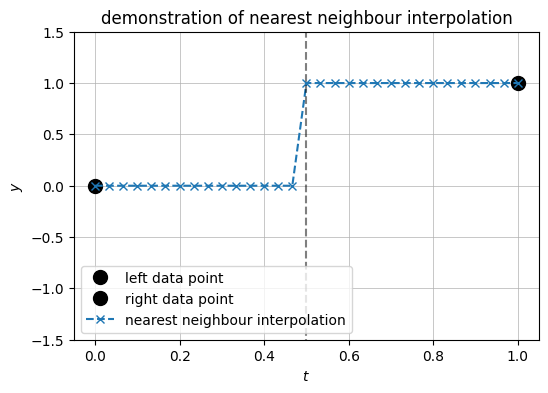

In [7]:
# nearest neighbour for a simple case, done manually in a slow way

def nearest_neighbour(tl, tr, yl, yr, tm):
    """takes in (tl, yl) and (tr, yr) [left and right] to give a (tm, ym) by nearest neighbour"""
    dl = np.abs(tm - tl)
    dr = np.abs(tm - tr)
    if dl < dr:
        ym = yl
    else:  # happen to make the decision to take half way value to be the one on the right
        ym = yr
    return ym

tl, tr = 0.0, 1.0
yl, yr = 0.0, 1.0
t = np.linspace(0.0, 1.0, 31)
y_nearest = np.zeros(len(t))
for i in range(len(t)):
    y_nearest[i] = nearest_neighbour(tl, tr, yl, yr, t[i])
    
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(tl, yl, 'ko', markersize=10, label="left data point")
ax.plot(tr, yr, 'ko', markersize=10, label="right data point")
ax.plot(t, y_nearest, 'x--', label="nearest neighbour interpolation")
ax.plot([0.5, 0.5], [-2, 2], 'k--', alpha=0.5)
ax.set_ylim([-1.5, 1.5])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.legend()
ax.grid(lw=0.5, zorder=0)
ax.set_title("demonstration of nearest neighbour interpolation")

> <span style="color:red">**Q.**</span> Try changing the above so that the subroutine returns the averaged data value at the two ends at the middle.

> <span style="color:red">**Q.**</span> Try vectorising the above, i.e. do the above without the `if` and `for` loop (hint: you could use the way I generated the logical booleans above to do subselection).

**Linear interpolation** is when you draw a straight line through two points, and you assign the value in between by whatever is on the straight line, and is done through the usual secondary (primary?) school trigonometry or algebra (it's just right angle triangles or simultaneous equations). Either you do
\begin{equation*}
    y = mt + c, \qquad m = \frac{y(t_2) - y(t_0)}{t_2 - t_0}, \quad c = y(t_0) - m t_0
\end{equation*}
where $m$ is the linear gradient between two the points and $c$ is a constant you need to fix (I used $(t_0, y(t_0))$, but $(t_2, y(t_2))$ works just as well), or you have the simultaneous equation
\begin{align*}
    y(t_0) &= m t_0 + c\\
    y(t_2) &= m t_2 + c
\end{align*}
and solve for $m$ and $c$ as the unknowns. Either way, you get your $y=mt + c$ by computing the value for $m$ and $c$ given known values, and the result is a calculator that gives you an interpolated $y$ every time you give it a $t$. The below code does this using the same simple example as above.

Text(0.5, 1.0, 'demonstration of linear interpolation')

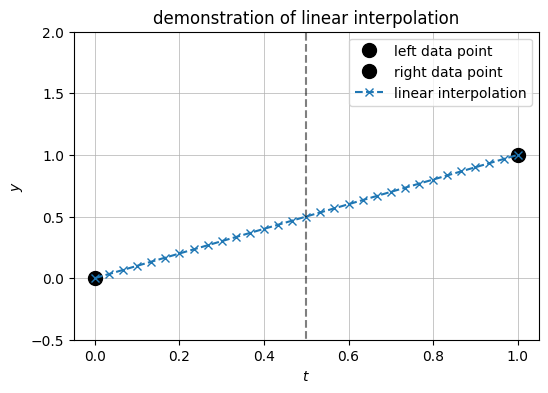

In [8]:
# nearest neighbour for a simple case, done manually in a slow way

def linear_interpolation(tl, tr, yl, yr, tm):
    """takes in (tl, yl) and (tr, yr) [left and right] to give a (tm, ym) by linear interpolation"""
    m = (yr - yl) / (tr - tl)
    c = yl - m*tl
    
    ym = m * tm + c
    
    return ym

tl, tr = 0.0, 1.0
yl, yr = 0.0, 1.0
t = np.linspace(0.0, 1.0, 31)
y_linear = np.zeros(len(t))
for i in range(len(t)):
    y_linear[i] = linear_interpolation(tl, tr, yl, yr, t[i])
    
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(tl, yl, 'ko', markersize=10, label="left data point")
ax.plot(tr, yr, 'ko', markersize=10, label="right data point")
ax.plot(t, y_linear, 'x--', label="linear interpolation")
ax.plot([0.5, 0.5], [-2, 2], 'k--', alpha=0.5)
ax.set_ylim([-0.5, 2.0])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.legend()
ax.grid(lw=0.5, zorder=0)
ax.set_title("demonstration of linear interpolation")

> <span style="color:red">**Q.**</span> Have a think what you should expect to get if you ask for an interpolated value at $t_0$, $t_m = (t_0 + t_2) / 2$ and $t_2$. Check that the expected values are really what you get from the calculator above. Show that this has to be the case algebraically if you are feeling up to the challenge.

> <span style="color:red">**Q.**</span> Try vectorising the above also (this is easier to do than the previous case because there is no `if` loop in the subroutine).

While the above is more for demonstration on how you might do it by hand, there are existing routines to do it already, from `scipy.interpolate.interp1d` (the general interpolation package is `scipy.interpolate`, and we are using the subpackage `interp1d` because we only have 1 dimension here). The below cases demonstrate the syntax for how you would do this for the same simple example as above.

> NOTE: Notice the nearest neighbour result here gives a different result at the mid point the my custom calculator, because of different conventions used. There is no strong reason for either choice as far as I can tell (e.g. one could just as well take the average value for these isolated midpoint cases), so just be aware of these kind of little quirks.

> NOTE: `interp1d` is considered as legacy package and is not supported anymore. It will work, but it won't be updated in future updates. We will still use it, but there are alternatives to do the same thing with other routines.

Text(0.5, 0.98, 'demonstration of scipy.interpolate.interp1d')

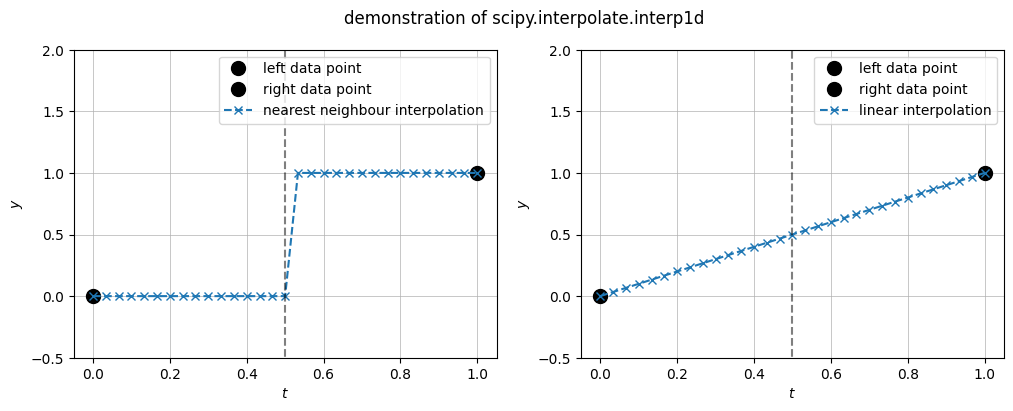

In [9]:
# demonstration of creating an interpolator object and using it

# define initial params as before
tl, tr = 0.0, 1.0
yl, yr = 0.0, 1.0
t = np.linspace(0.0, 1.0, 31)

nearest_interp = interpolate.interp1d([tl, tr], [yl, yr], kind="nearest")
y_nearest1 = nearest_interp(t)

linear_interp = interpolate.interp1d([tl, tr], [yl, yr])  # default is kind="linear" already
y_linear1 = linear_interp(t)

fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(tl, yl, 'ko', markersize=10, label="left data point")
ax.plot(tr, yr, 'ko', markersize=10, label="right data point")
ax.plot(t, y_nearest1, 'x--', label="nearest neighbour interpolation")
ax.plot([0.5, 0.5], [-2, 2], 'k--', alpha=0.5)
ax.set_ylim([-0.5, 2.0])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.legend()
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
ax.plot(tl, yl, 'ko', markersize=10, label="left data point")
ax.plot(tr, yr, 'ko', markersize=10, label="right data point")
ax.plot(t, y_linear1, 'x--', label="linear interpolation")
ax.plot([0.5, 0.5], [-2, 2], 'k--', alpha=0.5)
ax.set_ylim([-0.5, 2.0])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.legend()
ax.grid(lw=0.5, zorder=0)

fig.suptitle("demonstration of scipy.interpolate.interp1d")

If you try and do extrapolation via doing e.g. `nearest_interp(2)`, you will find this fails (do try it yourself). The error basically tells you what is wrong: you are trying to ask for a value outside the original data range, and the routine kills it by default (for good reason in my opinion). You could in principle override this as in the following:

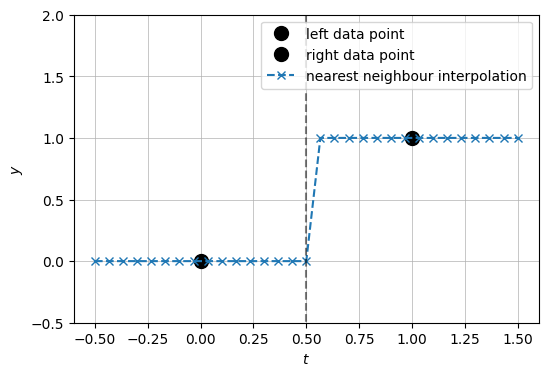

In [10]:
# option to extrapolate: do this at FITTING stage, and you need BOTH things in

nearest_interp = interpolate.interp1d([tl, tr], [yl, yr], kind="nearest",
                                     bounds_error=False, fill_value="extrapolate")
t_long = np.linspace(-0.5, 1.5, 31)
y_nearest2 = nearest_interp(t_long)

fig = plt.figure(figsize=(6, 4))

ax = plt.axes()
ax.plot(tl, yl, 'ko', markersize=10, label="left data point")
ax.plot(tr, yr, 'ko', markersize=10, label="right data point")
ax.plot(t_long, y_nearest2, 'x--', label="nearest neighbour interpolation")
ax.plot([0.5, 0.5], [-2, 2], 'k--', alpha=0.5)
ax.set_ylim([-0.5, 2.0])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.legend()
ax.grid(lw=0.5, zorder=0)

> <span style="color:red">**Q.**</span> The above extrapolation will simply refuse to work for linear interpolation, why is that? Either way, how might you get over that? (hint: text below)

> <span style="color:red">**Q.**</span> Within the existing structure of the linear interpolator you can force it to do nearest neighbour extrapolation; see how you might do that.

For a slightly more sophisticated example, we go back to our linear line with missing data. What the linear and nearest neighbour interpolation routine will do when multiple pairs of data points are provided is to build an interpolator for each pair of given points, leading to a **piecewise nearest neighbour / linear interpolator**. Put another way, a point $y(t_1)$ for $t_1$ between $t_0$ and $t_2$ is joined by the appropriate straight line joining the points $y(t_0)$ and $y(t_2)$, and it simply does not care about any of the other straightlines created for other pairs of points outside of the $t_0$ and $t_2$ range.

For the case with `nan`s, we are going to omit the data points with `nan`s and create the interpolator that way. The routine below does this (and I really am just copy and pasting accordingly here).

> NOTE: For this particular case my left most point gets masked, so the routine complains because it's trying to do extrapolation and I gave it `t` values that are out of bounds. Here I overrode this by allowing extrapolation (`bounds_error=False`), but filling it up with `nan`s (`fill_value=np.nan`) if it is out of bounds.

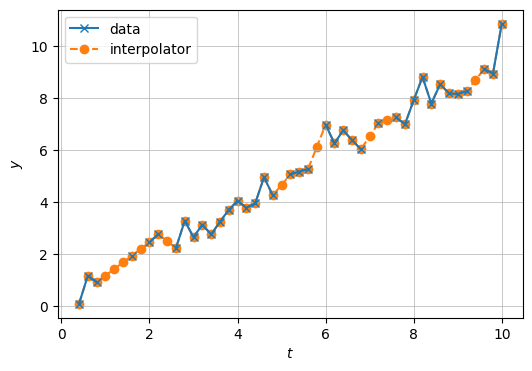

In [11]:
# doing a piecewise interpolation

seed = np.random.seed(69)
n = 51
t = np.linspace(0, 10, n)
data_mod  = np.linspace(0, 10, n)  # straight line, then add some noise to it (cf. workbook 03)
noise = 2.0 * (np.random.rand(n) - 0.5)
data_mod += noise
ind = np.random.randint(0, n, size=15)
data_mod[ind] = np.nan

# linear interpolation (only throwing the non-nan values in)
lin_interp = interpolate.interp1d(t[~np.isnan(data_mod)],         # t values
                                  data_mod[~np.isnan(data_mod)],  # y values
                                  bounds_error=False,             # for extrapolation
                                  fill_value=np.nan
                                  )
data_lin_interp = lin_interp(t)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.plot(t, data_mod, "x-", label = f"data")
ax.plot(t, data_lin_interp, "o--", label = f"interpolator", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

As can be seen, the interpolator fills up the internal blank points accordingly. On my computer with the chosen seed number, there is a clear bit on the left hand corner where there is a chunk of points following a straight line, as it should given the chunk of blanked out data there.

# c) Splines

The above routines do piecewise-linear interpolation, and one could in principle swap out the interpolator and use regression instead (then you could do extrapolation if you really wanted to). And if we can do regression, then we can in principle to piecewise-polynomial interpolation too. The actual algorithms are probably a bit tricky, not overly efficient, and there are some other mathematical issues that are not obvious to fix; see exercise at the end of the notebook.

We will go straight to **splines** even though the "obvious" extension might be piecewise-polynomial interpolation. The word "spline" (rhymes with "pine" the tree apparently) comes from the things people used to use to draw curves for building ships for example (image from Wikipedia):

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Spline_%28PSF%29.png/800px-Spline_%28PSF%29.png" width="400" alt='ship spline'>

You pin them down at the appropriate ends and let it relax accordingly into a curve; there are some mechanical reasons that the relax/least tension part is useful.

Mathematically splines are piecewise-polynomials, but with additional properties. For example, given three points $t_{0,1,2}$, a spline would be a (probably different) polynomial on the interval between $t_0$ and $t_1$, and $t_1$ and $t_2$, and they are joined at $t_1$. For a piecewise-linear interpolation, the resulting curve would be continuous at $t_1$ but would have a kink, i.e. it is not smooth/differentiable at joining points such as $t_1$. A spline of order $n$ would have $n-1$ derivative in general: it is not only continuous everywhere, the derivatives are continuous up to a certain point, so splines are more "smooth".

Easiest to show an example. Below is some code to generate a cubic spline on a sample data above.

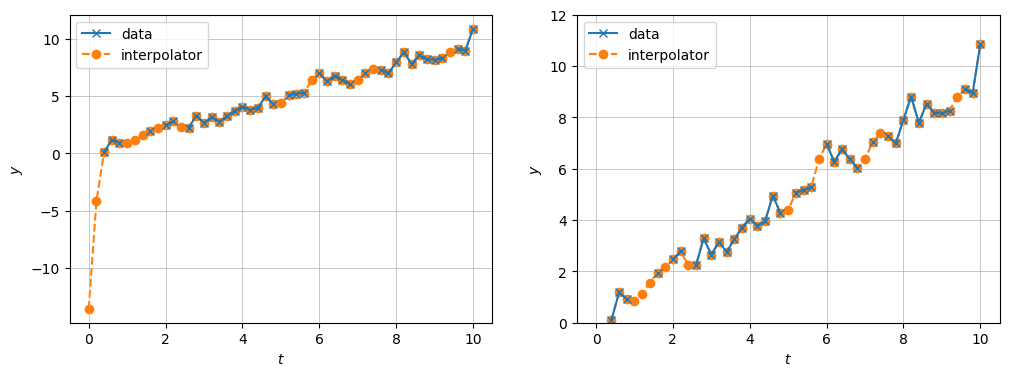

In [12]:
# spline interpolation

seed = np.random.seed(69)
n = 51
t = np.linspace(0, 10, n)
data_mod  = np.linspace(0, 10, n)  # straight line, then add some noise to it (cf. workbook 03)
noise = 2.0 * (np.random.rand(n) - 0.5)
data_mod += noise
ind = np.random.randint(0, n, size=15)
data_mod[ind] = np.nan

# cubic spline interpolation (only throwing the non-nan values in)
spline_interp = interpolate.CubicSpline(t[~np.isnan(data_mod)],         # t values
                                        data_mod[~np.isnan(data_mod)],  # y values
                                        )
# spline_interp = interpolate.interp1d(..., kind = "cubic") would work too
data_spline = spline_interp(t)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data_mod, "x-", label = f"data")
ax.plot(t, data_spline, "o--", label = f"interpolator", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(t, data_mod, "x-", label = f"data")
ax.plot(t, data_spline, "o--", label = f"interpolator", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_ylim([0, 12])
ax.grid(lw=0.5, zorder=0);
ax.legend()

Notice there are no issues with cubic spline extrapolating for values, but we have quite a bit of overshooting; in this case this is analogous to fitting with a high degree polynomial from `04_regression`, so is in some sense no worse. In the interior points where we do interpolation, the results are not overly dissimilar to the piecewise-linear interpolation; the result is slightly more smooth perhaps.

A better example demonstrating a desirable feature of splines over polynomial fitting would be the following (a scaled witch of Agnessi, see https://en.wikipedia.org/wiki/Runge%27s_phenomenon):

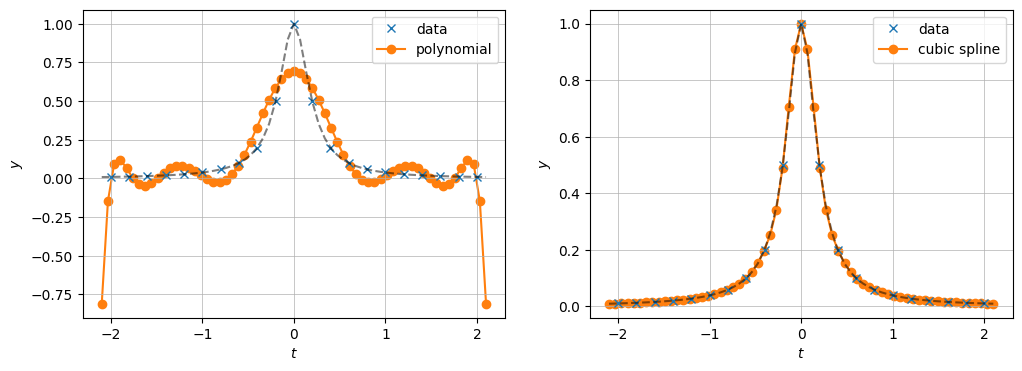

In [13]:
# fitting with witch of Agnessi with no missing data

n = 21
t = np.linspace(-2, 2, n)
data_mod  = 1.0 / (1.0 + 25*t**2)  # witch of Agnessi

t_fine = np.linspace(-2.1, 2.1, 3*n)

# fitting with a high degree polynomial
p = np.polyfit(t,         # t values
               data_mod,  # y values
               10)

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t, data_mod, "x", label = f"data")
ax.plot(t_fine, 1.0 / (1.0 + 25*t_fine**2), "k--", alpha=0.5)
ax.plot(t_fine, np.polyval(p, t_fine), "o-", label = f"polynomial", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

# cubic spline fitting
spline_interp = interpolate.CubicSpline(t,         # t values
                                        data_mod,  # y values
                                        )

ax = plt.subplot(1, 2, 2)
ax.plot(t, data_mod, "x", label = f"data")
ax.plot(t_fine, 1.0 / (1.0 + 25*t_fine**2), "k--", alpha=0.5)
ax.plot(t_fine, spline_interp(t_fine), "o-", label = f"cubic spline", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.grid(lw=0.5, zorder=0);
ax.legend()

Notice here I supply the interpolator with less data (`t`), but evaluate it on more data (`t_fine`) that also has out of bounds values.

Here the polynomial is of degree 10 (so goes up to $t^{10}$), but it has a lot of problems trying to get that sharp peak, which also leads to a lot of wriggles at the ends, and has quite substantial overshoots.

By contrast, none of that shows up for the cubic spline (i.e. goes up to $t^3$) spline, because this fitting is not a global one like the polynomial regression above, but a local piecewise one. At the peak it bends as much as it can as descrbied by the cubic term, and away from the peak it flattens out as much as it likes, which also means extrapolation is ok.

> <span style="color:red">**Q.**</span> Evaluate the cubic spline close to the peak (don't just zoom in) and see how well it really does there. Convince yourself it is still smooth there (more precisely it is smooth enough that even after two derivatives the result is still continuous).

Below example shows a noisy oscilatory example, in anticipation of some example analysis we will do shortly.

Text(0.5, 1.0, 'cubic spline')

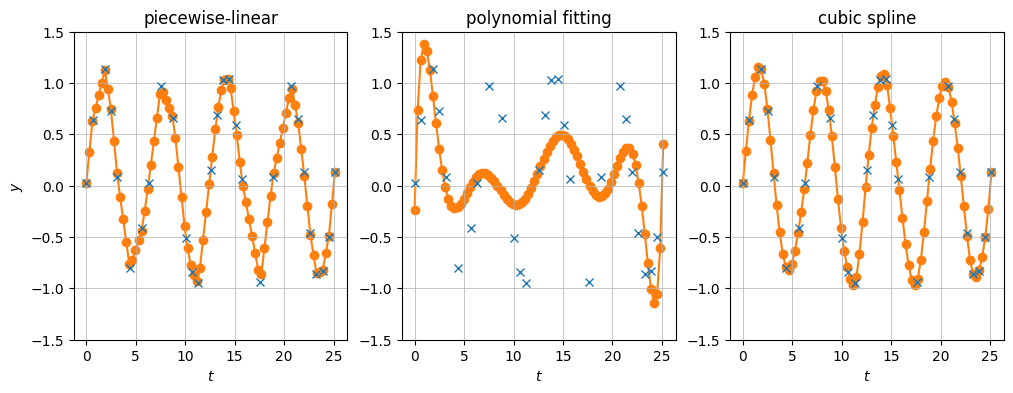

In [14]:
# noisy oscillatory data with missing entries as a demonstrative example

seed = np.random.seed(4167)
n = 41
t = np.linspace(0, 8*np.pi, n)
data_mod  = np.sin(t)
noise = 0.2*np.random.rand(n)
data_mod += noise
ind = np.random.randint(0, n, size=15)
data_mod[ind] = np.nan

t_fine = np.linspace(0, 8*np.pi, 2*n)

fig = plt.figure(figsize=(12, 4))

# piecewise linear fitting
linear_interp = interpolate.interp1d(t[~np.isnan(data_mod)],         # t values
                                     data_mod[~np.isnan(data_mod)],  # y values
                                     )

ax = plt.subplot(1, 3, 1)
ax.plot(t, data_mod, "x")
# ax.plot(t_fine, np.sin(t_fine), "k--", alpha=0.5)
ax.plot(t_fine, linear_interp(t_fine), "o-", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
ax.set_ylim([-1.5, 1.5])
ax.grid(lw=0.5, zorder=0)
ax.set_title("piecewise-linear")

# fitting with a high degree polynomial
p = np.polyfit(t[~np.isnan(data_mod)],         # t values
               data_mod[~np.isnan(data_mod)],  # y values
               10)

ax = plt.subplot(1, 3, 2)
ax.plot(t, data_mod, "x", label = f"data")
# ax.plot(t_fine, np.sin(t_fine), "k--", alpha=0.5)
ax.plot(t_fine, np.polyval(p, t_fine), "o-", label = f"polynomial", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
# ax.set_ylabel(r"$y$")
ax.set_ylim([-1.5, 1.5])
ax.grid(lw=0.5, zorder=0)
ax.set_title("polynomial fitting")

# cubic spline fitting
spline_interp = interpolate.CubicSpline(t[~np.isnan(data_mod)],         # t values
                                        data_mod[~np.isnan(data_mod)],  # y values
                                        )

ax = plt.subplot(1, 3, 3)
ax.plot(t, data_mod, "x")
# ax.plot(t_fine, np.sin(t_fine), "k--", alpha=0.5)
ax.plot(t_fine, spline_interp(t_fine), "o-", zorder=-1)  # put line "lower"
ax.set_xlabel(r"$t$")
# ax.set_ylabel(r"$y$")
ax.set_ylim([-1.5, 1.5])
ax.grid(lw=0.5, zorder=0)
ax.set_title("cubic spline")

Arguably cubic spline works the best here, preserving some of the turning behaviour of an oscillatory signal (none of the janky-ness of the piecewise-linear interpolator) or the siginificant mismatches from the polynomial fitting (polynomials are not oscillatory so it is not a surprise it doesn't function well here).

> <span style="color:red">**Q.**</span> Polynomials are not oscillatory but sines and cosines are, and these can be shown to outperform splines in some loose sense if you know you are dealing with oscillatory/periodic signals. Look up how you might do this (hint: you want to look up Fourier transforms proably; see also the previous published version of `08_time_series`).

## working out rates of change or total changes 

(Differentiation and integrals!)

Population growth

Mary Tai glucose response

integral of oxygen concentration change = volume of oxygen used up or whatever

Below example shows an analytical example where we know what the answer is before we compute. Suppose for population $y$ as a function of $t$ we have population growth described as an exponential given by
\begin{equation*}
    y(t) = y_0 \mathrm{e}^{\lambda t},
\end{equation*}
where $y_0 = y(0)$ is the initial population (interpreted loosely so non-integer values are acceptable), and $\lambda$ is a growth rate (or $e$-folding rate) with units $1\mathrm{time}$. Then elementary calculus (chain rule if you like) tells us that the rate of change of population is
\begin{equation*}
    \frac{\mathrm{d}y(t)}{\mathrm{d}t} = y_0 \lambda \mathrm{e}^{\lambda t}.
\end{equation*}
This is exactly like the radioactive decay example given in `03_regression`, but with a growth instead of decay rate. Below example shows how cubic spline fitting could be used to numerically compute the values of the derivative. The thinking goes:

* fit the data with a spline
* compute the derivative (numerically easy, since splines are just polynomials)
* evaluate at the points you want
* (check against the closed form solution)

Below code basically does that for the first derivative.

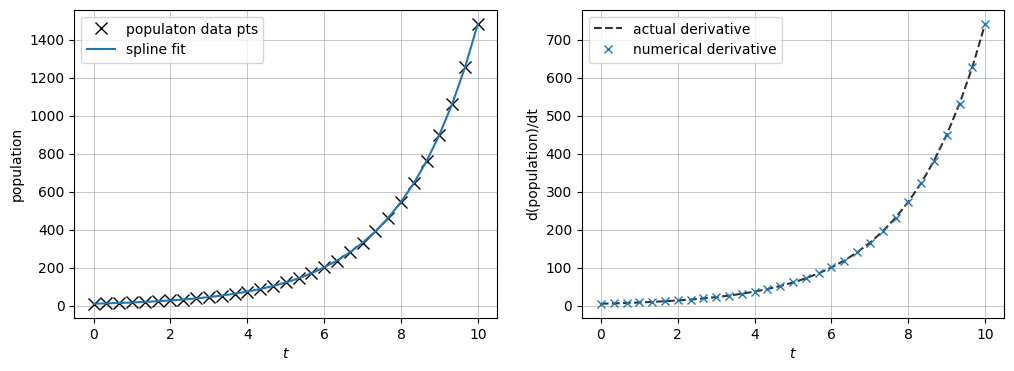

In [15]:
# population growth example (cf. the radioactie decay example in 03_regression for negative lam)

t = np.linspace(0, 10, 31)
y0, lam = 10, 0.5
y = y0 * np.exp(lam * t)
dy = lam * y

spline_y  = interpolate.CubicSpline(t, y)  # fit a cubic spline
spline_dy = spline_y.derivative(nu=1)      # take the derivative (note we the interpolator here)

# evaluate both the function and derivative at the original points just for checking
y_interp  = spline_y(t)
dy_interp = spline_dy(t)

fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(t, y, 'kx', markersize=8, label="populaton data pts")
ax.plot(t, y_interp, '-', label="spline fit")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"population")
ax.grid(lw=0.5, zorder=0)
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(t, dy, 'k--', alpha=0.8, label="actual derivative")
ax.plot(t, dy_interp, 'x', label="numerical derivative")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"d(population)/dt")
ax.grid(lw=0.5, zorder=0)
ax.legend()

Previously in `03_regression` we did a regression on the log of the data to infer for the growth rate $\lambda$. An alternative approach here would be to divide `dy_interp` with `y_interp` (and probably take an average of the values say).

> <span style="color:red">**Q.**</span> Why? Can you do that generally for data that you think behaves like a power law? What if there is some noise in the data?

> <span style="color:red">**Q.**</span> Check that if you do the regression approach with the spline fitted data you can get the same lambda. What if there is noise in the data?

In [16]:
lam_interp = dy_interp / y_interp
print(f"inferred derivative value from spline fitting: mean(lam_interp) = {np.mean(lam_interp):.3f}")
print(f"                              actual input value is         lam = {lam:.3f}")

inferred derivative value from spline fitting: mean(lam_interp) = 0.500
                              actual input value is         lam = 0.500


Can go the other way too. Suppose I have a hypothetical chemical experiment where I can only measure the *rate* of oxygen consumption $y(t)$ as a function of time $t$. What I really want is the amount of oxygen $Y(t)$ used up over time. We effectively want to compute the (definite) integral of $y(t)$ with respect to time; viewed another way, oxygen content is then the area under the curved traced out by $y(t)$. From a units points of view, since the rate of oxygen consumption has units (say) $\mathrm{mol} / \mathrm{rm}$, and oxygen content has units $\mathrm{mol}$, then you want to multiply the former by time somehow to make the units agree: computing the area under the curve $y(t)$ effectively does that, and computing the area under the curve is basically doing an integral.

There are several approaches to do this:

* given data points, you approximate the area under the curve by drawing rectangles, and then sum those up (have to make a choice about the time interval)
* given data points, you approximate the area under the curve by draawing trapeziums, and then sum those up (this is basically the <a href="https://en.wikipedia.org/wiki/Trapezoidal_rule">trapezoidal rule</a>, and can be done with piecewise-linear interpolation if you want, or just use `np.trapz` in python)
* fit a spline, and since we just have polynomials on each segment, we can "analytically" integrate over each segment (because integration of polynomials is just reverse of derivatives, and both are "easy"), and then sum it up accordingly

I am going to do the last one using a cooked up example where I roughly know what answer I should get. Suppose my oxygen concentration is described by
\begin{equation*}
    y(t) = y_0 (\sin(\omega t) + $2.0$) \mathrm{e}^{-\lambda t},
\end{equation*}
where $y_0$ is some scaling factor, the sin term gives some oscillation, the 2.0 is to stop it being negative or zero, and the exponential gives me a decay (so this is an oscillatory decay to zero). The total oxygen usage is over the whole time period, and is area under the curve given by the definite integral
\begin{equation*}
    \mathrm{total\ usage} = Y(T) = \int_0^T y_0 (\sin(\omega t) + 2.0) \mathrm{e}^{-\lambda t}\; \mathrm{d}t.
\end{equation*}
For $T$ sufficiently large (that $\lambda t$ is "big" in some sense that can be more precise), I make it that
\begin{equation*}
    \mathrm{total\ usage} \approx y_0 \left(\frac{\omega}{\lambda^2 + \omega^2} + \frac{2}{\lambda}\right).
\end{equation*}
Below code checks the demonstrates the way to do the spline fitting and plot $Y(t)$ first.

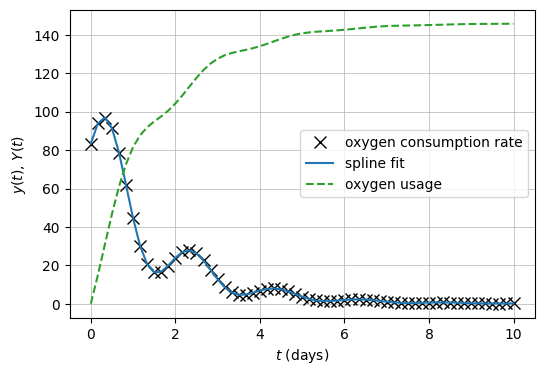

In [17]:
# cook up a function, do spline fitting and plot the cumulative integral

t = np.linspace(0, 10, 61)  # units of days
y0 = 1000.0/24.0            # 1000 mg/kg/hr = 1000/24 mg/kg/day for a fairly active fish
lam = 15.0/24.0
omega = 0.5 * (2.0 * np.pi) # frequency of oscillation (half a day here)

y = y0 * (np.sin(omega * t) + 2.0) * np.exp(-lam * t)

spline_y = interpolate.CubicSpline(t, y)   # fit a cubic spline
spline_Y = spline_y.antiderivative(nu = 1) # compute an integral

# evaluate both the function and derivative at the original points just for checking
y_interp = spline_y(t)
Y_interp = spline_Y(t)

fig = plt.figure(figsize=(6, 4))

ax = plt.axes()
ax.plot(t, y, 'kx', markersize=8, label="oxygen consumption rate")
ax.plot(t, y_interp, '-', label="spline fit")
ax.plot(t, Y_interp, 'C2--', label="oxygen usage")
ax.set_xlabel(r"$t$ (days)")
ax.set_ylabel(r"$y(t)$, $Y(t)$")
ax.grid(lw=0.5, zorder=0)
ax.legend()

The total usage involves evaluating the definite integral, and can be computed in multiple ways. Below are a few choices (note the slight differences in syntax for the different choices). My derived approximated solution is a little too big, but roughly in the right area.

In [18]:
# compare the various computations

asymptotic_value = y0 * (omega / (lam**2 + omega**2) + 2.0 / lam)

print(f"asymptotic value                                         = {asymptotic_value:.4f}")
print(f"integral via")
print(f"   trapezoidal rule          : np.trapz(y, x=t)          = {np.trapz(y, x=t):.4f}")
print(f"   anti-derivative of spline : spline_Y(10)              = {spline_Y(10):.4f}")
print(f"   fitted spline directly    : spline_y.integrate(0, 10) = {spline_y.integrate(0, 10):.4f}")

asymptotic value                                         = 146.0913
integral via
   trapezoidal rule          : np.trapz(y, x=t)          = 145.6259
   anti-derivative of spline : spline_Y(10)              = 145.8153
   fitted spline directly    : spline_y.integrate(0, 10) = 145.8153


Just a note before we go to examples dealing with "real data". Note that the total usage $Y(t)$ could have been obtained from a cumulative integral (e.g. `np.cumsum`), although the accuracy probably wouldn't be great. The point of possible interest is that $Y(t)$ and $y(t)$ are essentially like the cumulative distribution functions (CDFs) and probability distribution functions (PDFs), from `05/06_statistical_tests`. A point raised previously is that if you have the PDF you basically have all the statistics you care about; the above techniques provide ways to augment the construction of these objects, so would potentially be beneficial for related applications.

There are also other types of splines or interpolators one could use; see end of notebook exercise. We will also revisit some of these when dealing with spatial data (`09/10_fun_with_maps`).

> <span style="color:red">**Q.**</span> A place where the above kind of fitting might be useful is in fitting the probability density functions (PDFs) from a histogram, and/or doing integrals to get the cumulative density functions (CDFs); see `05/06_statistical_tests`. Revisit the previous workbooks (or make your own from scratch) and try and apply techniques above to that. (e.g. start from a PDF and get to a CDF, or vice-versa).

> <span style="color:red">**Q.**</span> (Technical) By construction the histograms look less "good" but are probably better behaved mathematically as PDFs, i.e. interpolation as above might cause the PDFs and/or CDFs to not be mathematically valid. Why is that, and how might you fix it? (hint: what should the total probability be?)

--------------------
# d) Example with real data: (broken) tide gauge data

Going to apply what we have introduced to some real data. The file `Tobermory_20160430_20161231_broken.csv` consists of tide gauge data of the sea level (above datum) at the town of Tobermory on the island of Mull in Scotland, from May to December of 2016, with records at every 15 minutes, but I broke the data on purpose. The data is a small segment of a longer time series that was originally obtained from [BODC](https://www.bodc.ac.uk/).

<img src="https://i.imgur.com/O5wICRf.jpg" width="800" alt='Tobermory'>

(Modified photos of Tobermory demonstrating tides; left is from the www.thechaoticscot.com, the right photo is one of mine.)

The full file itself has lots of other entries, but the broken file I cooked up for this case only contains the date and the values, which `Pandas` can read for us. Lets do step zero of data analysis and plot it out as well to see what it looks like.

loading data locally (assumes file has already been downloaded)


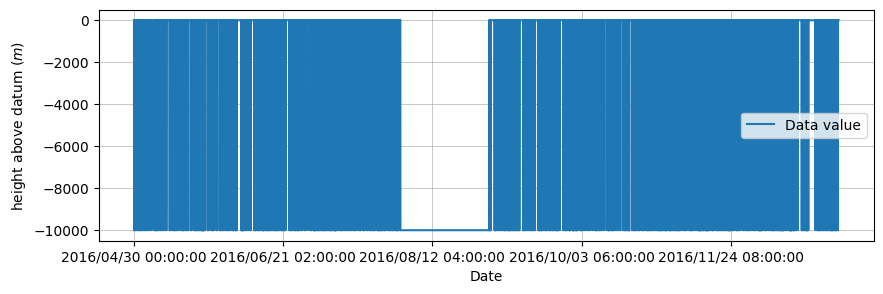

In [19]:
# read tobermory tide file remotely or locally

option = "local"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file_loc = "Tobermory_20160430_20161231.csv"
elif option == "remote":
    print("loading data remotely")
    file_loc = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/Tobermory_20160430_20161231.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(file_loc, skipinitialspace=True, usecols=["Date", "Data value"])

# raw plot to see what it looks like
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
df.plot(x="Date", ax=ax)
ax.set_ylabel(r"height above datum ($m$)")
ax.grid(lw=0.5, zorder=0)

Well looks like nonsense doesn't it? There are several hints, either by looking into the data file itself (it's just a text file) or do a print will probably show you what is going on: there are values that clearly don't belong in the dataset, presumably corresponding to masked values.

In [20]:
df

,Date,Data value
0,2016/04/30 00:00:00,3.328
1,2016/04/30 00:15:00,-9999.999
2,2016/04/30 00:30:00,3.250
3,2016/04/30 00:45:00,3.194
4,2016/04/30 01:00:00,3.137
...,...,...
23611,2016/12/31 22:45:00,2.518
23612,2016/12/31 23:00:00,2.303
23613,2016/12/31 23:15:00,2.094
23614,2016/12/31 23:30:00,1.884


First easy thing is to `nan` out the masked values to see if gives something sensible. Doing it here by finding indices corresponding to the mask value (there may well be more than one of these, but in this case there really is only one, because I made it so). I also modify the format of the `Date` entries to make the axes look less terrible.

> NOTE: You might get a warning here about pands not liking the fact that some data is being overwritten from a copy of a slice. In this case you can probably safely ignore this.

/tmp/ipykernel_1176030/3864889293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Data value"].iloc[mask_ind] = np.nan


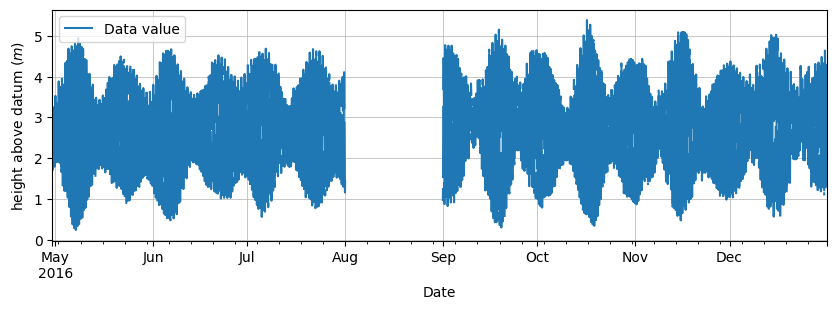

In [21]:
# nan out the masked values and do a plot
mask_ind = np.where((df["Data value"] == -9999.999))[0]
df["Data value"].iloc[mask_ind] = np.nan

# turn the "Date" into the python DateTime format for formatting reasons below
df["Date"] = pd.to_datetime(df["Date"])

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
df.plot(x="Date", ax=ax)
ax.set_ylabel(r"height above datum ($m$)")
ax.grid(lw=0.5, zorder=0)

So there are miscellaneous points broken in the rather dense data that you can see, but those don't affect the plots and is probably not a huge problem to fill out with interpolation. 

A more problematic observation is that there is a whole chunk of data missing in time (which happens to correspond to the month of August); this could be broken instrument, loss of data, manual sabotage (as is the case here), or others. Depending on the question being asked of the data, a decision needs to be made as to what is to be done. 

It is probably quite dubious to interpolate that block as is; for this particular case I am actually just going to leave it blank and not touch it. I am going to further just select the the data in the month of May, interpolate for the missing points, and then do a filtering and compute its spectrum as a demonstration. First I am going to subselect and plot the first block of data.

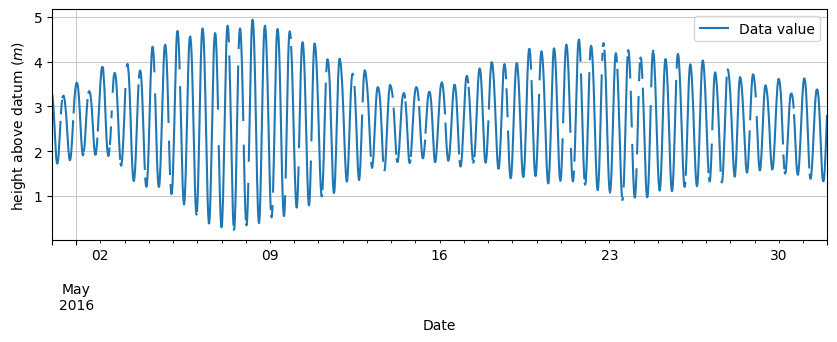

In [22]:
# select the May data

dg = df.loc[(df["Date"] > "2016/04/30") & (df["Date"] < "2016/06/01")]

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
dg.plot(x="Date", ax=ax)
ax.set_ylabel(r"height above datum ($m$)")
ax.grid(lw=0.5, zorder=0)

There are clearly points that are missing and we want to fill that in. The thing to be aware is that the interpolation needs a bit of care, because `Date` entries are not by default ordered in a way that the interpolation understands: it really wants it as a string of numbers. The ordering of routines below is that 

* we convert the `Date` into an intermediate array of numbers (something sensible will do, as we will not use that intermediate array for plotting purposes anyway)
* create the interpolator and evaluate at the locations of that intermediate array
* overwrite the old `Data value` array with the interpolated one.

For comparison reasons I am going to augment the original data frame (`dg` here) with some extra columns for comparison reasons; in practice I would just overwrite the original column(s).

/tmp/ipykernel_1176030/401992613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg["seconds"] = (dg["Date"] - ref_time).dt.total_seconds()
/tmp/ipykernel_1176030/401992613.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg["interp data"] = spline_interp(dg["seconds"])


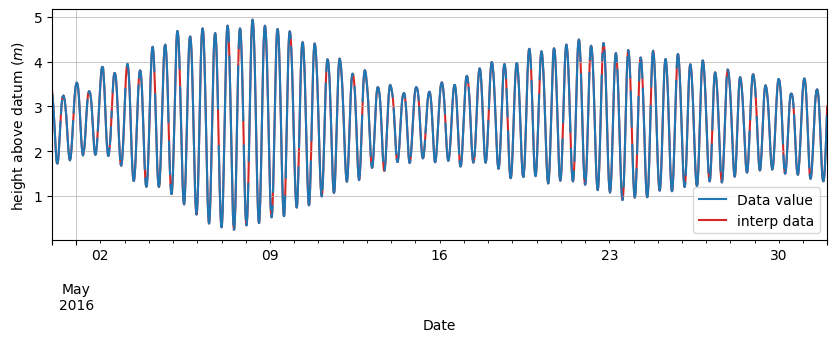

In [23]:
# create an arbitrary time as a reference
ref_time = datetime(2016, 4, 1)
dg["seconds"] = (dg["Date"] - ref_time).dt.total_seconds()

# interpolator but do not throw in the nans
ind = ~np.isnan(df["Data value"])  # find the NOT nans
spline_interp = interpolate.CubicSpline(dg["seconds"].loc[ind], dg["Data value"].loc[ind])

# evaluate intepolator at every single point (it should not matter for points already with data on)
dg["interp data"] = spline_interp(dg["seconds"])

# plot both the original and interpolated data, but put the orignal data ABOVE the new one
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
dg.plot(x="Date", y="Data value", ax=ax)
dg.plot(x="Date", y="interp data", ax=ax, zorder=0, color="C3")
ax.set_ylabel(r"height above datum ($m$)")
ax.grid(lw=0.5, zorder=0)

Going to compute the power spectrum as in the last notebook with the now interpolated data.

> <span style="color:red">**Q.**</span> Think before you compute: if you do get peaks then what should these peaks correspond to? In particular, what do you think the largest peak corresponds to? (Hint: what generates tides on Earth?) 
>
> <span style="color:red">**Q.**</span> Convince yourself the choice of sampling rate make sense with my choice of units displayed on the graph.
>
> <span style="color:red">**Q.**</span> I didn't remove mean or detrend the data, should I have? Does it matter?

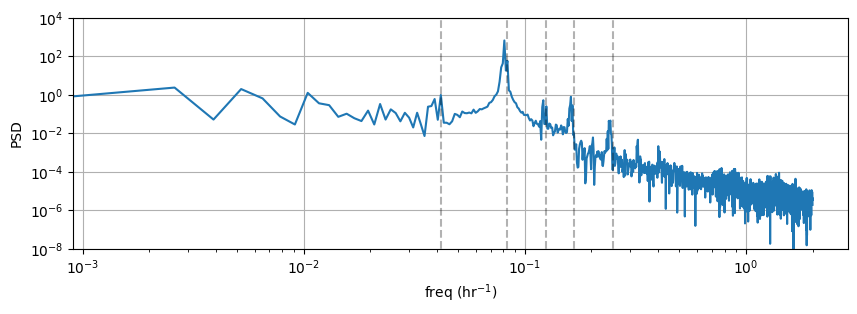

In [24]:
# PSD of the interpolated data

freq, psd = signal.periodogram(dg["interp data"], fs=4)
psd[0] = 0.0

fig = plt.figure(figsize=(10, 3))
ax = plt.axes()
ax.loglog(freq, psd)
ax.loglog([1/12, 1/12], [0, 1e4], 'k--', alpha=0.3)
ax.loglog([1/24, 1/24], [0, 1e4], 'k--', alpha=0.3)
ax.loglog([1/6, 1/6], [0, 1e4], 'k--', alpha=0.3)
ax.loglog([1/4, 1/4], [0, 1e4], 'k--', alpha=0.3)
ax.loglog([1/8, 1/8], [0, 1e4], 'k--', alpha=0.3)
ax.set_ylim([1e-8, 1e4])
ax.set_xlabel(r"freq ($\mathrm{hr}^{-1}$)")
ax.set_ylabel("PSD")
ax.grid()

The big one is of course the semi-diurnal (twice daily principal lunar) M2 tide. I have plotted some dashed lines for the frequencies corresponding to the peaks, notably the

* diurnal tide (every day), left of the biggest peak
* some shorter tides with period of 8, 6 and 4 hours, right of the biggest peak

> <span style="color:red">**Q.**</span> The eagle eyed among you may notice the place where I marked on the M2 tide is not coinciding with the peak exactly. One reason is that for simplicity above I put the M2 tide to be twice daily, but in reality it is a bit more than 12 hours. Fix the value of the M2 frequency (or vice-versa do it for the period) and see if the agreement is better.
>
> <span style="color:red">**Q.**</span> Look up the other astronomical tidal modes (K1, S2, O1 etc.; see e.g. OCES 2003, lec 18 slides) and plot some of those on the graph too.
>
> <span style="color:red">**Q.**</span> (Coding) Like above, but instead bully the computer to pick out the say the period associated with the 10 largest peaks in the power spectrum, and compare these side by side with the 10 largest tidal modes we expect.
>
> <span style="color:red">**Q.**</span> The S1 diurnal tide should be relatively strong, but the signal is not so obvious, here, why is that? See if taking a longer time window would help.
>
> <span style="color:red">**Q.**</span> (Slightly different, not really Fourier series related.) Using the codes you already have, try and reproduce the following graph (you can ignore the formatting somewhat). The plots are of *daily max and mins of sea level* (i.e. max or min of sea level over a particular day). The graph shows the prescence of **spring tides** and **neap tides**.

<img src="https://i.imgur.com/JzBm8ok.png" width="800" alt='springs and neaps'>

> <span style="color:red">**Q.**</span> You probably shouldn't expect the spring and neap tide frequencies to come out in the PSD in the above data analysis, why is that? (hint: what is the frequency of the those tides?) Do PSD analysis again but for a period longer than a month, and see if you can additionally pick out the signals associated with the spring and neap tides.longerlonger

----------------
# More involved exercises with this notebook

## 1) Other interpolators

Two other popular (?) choices of splines are the `Akima1DInterpolator` and `PchipInterpolator`. Have a look to see what these do differently and try them out maybe. You will probably need to look up a bit more detail on the associated Wikipedia pages and/or the Python manual for example to construct some examples that really show how the different interpolators function under different conditions.

There are others interpolators too: have a look at what is built into Scipy.

## 2) Coatal marine station data (quite involved + open ended)

Apply what you learnt so far to the three sets of real coastal marine station data at an unspecified location in Asia given in e.g. `marine_station_data_1.csv` (replace `1` with `2` or `3` for data at two other stations I have subsetted out from a larger file). You can load it with pandas as in the following.

In [25]:
option = "local"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file_loc = "marine_station_data_3.csv"
elif option == "remote":
    print("loading data remotely")
    file_loc = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/marine_station_data_3.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(file_loc)
df

loading data locally (assumes file has already been downloaded)


,Unnamed: 0,Dates,Chlorophyll-a (μg/L),Salinity (psu),Temperature (°C),Total Nitrogen (mg/L),Total Phosphorus (mg/L),Turbidity (NTU),Dissolved Oxygen (mg/L)
0,0,1986-01-30,1.8,32.4,16.6,NaN,0.04,3.7,NaN
1,1,1986-03-14,1,31.8,15.5,NaN,0.04,4.6,NaN
2,2,1986-05-19,NaN,29.5,26.0,0.57,0.02,1.3,6.9
3,3,1986-07-14,1.1,12.5,27.3,0.62,0.05,2.3,6.2
4,4,1986-09-29,23,27.0,27.5,0.33,0.02,8.5,5.4
...,...,...,...,...,...,...,...,...,...
265,265,2019-08-17,3.1,23.0,29.2,0.75,0.04,2.7,5.4
266,266,2019-09-04,1,25.1,27.7,0.79,0.05,5.3,4.1
267,267,2019-10-11,1.5,28.9,29.3,0.63,0.05,5.7,5.1
268,268,2019-11-11,7.4,32.7,25.7,0.39,0.05,3.7,6.5


The data is nice in that the dates are sensible and the columns are labelled with units etc., but there are some subtleties you will want to be careful of (some of these are highlighted in the possible avenues of investigation below).

A few things to try and investigate using tools and techniques you already have at your disposal:

* There are some columns with `NaN`s floating around, might want to do something about those
* There are other subtle things you might need to deal with. For example, if you try and do `df["Chlorophyll-a (μg/L)"].plot()` it will fail with the error `no numeric data to plot`. Have a see why is going on (hint: try opening the file itself, or get python to spit out what is in the column). This happens for multiple columns.
* When analysing temperature, see if there is in fact a global warming trend, becaus the data is over a sufficiently long period. If you compute a PSD for temperature you may or may not want to remove the global warming trend.
* What are the seasonal cycles like? Is there a distinct shift in the seasonal characteristics over the years? (e.g. stronger hypoxia? water getting more fresh/saline in certain seasons?) Do this visually first, and then consider doing statistical tests (cf. `05/06_statistical_tests`).
* Are there strong correlations (or anti-correlation, lag correlation etc) between the different data sets? (cf. `07_time_series`)
* If there are strong correlations between two variables A and B say, try and create a model that uses A to predict B or vice-versa (cf. `03/04_regression`; e.g. Chlorophyll concentration might be something we might want to predict from other variables such as temperature and nitrogen).
* Instead of doing some/all of the things above at one station, what about comparing data at different stations? (The only thing I will tell you is that all stations are relatively close to each other.)
* Other things you can think of...

## 3) Piecewise-polynomial interpolation

More of a coding practise one. Write a code that does a sliding window linear regression that takes into account more points than the piecewise-linear interpolator provided by `scipy.interpolate.interp1d` or `np.interp` (which only uses two given data points). I would start probably start with something like:

1) given an interpolation point, find the two left points and right points with given data
2) do a linear regression on that, and evaluate the value
3) cycle through all the points

Things that could be improved are:

1) find all data points within some given distance and then do regression based on that
2) caching to save on having to do a search at every given point
3) error catching, when there are not enough points in the given distance to do regression

If you can do the above, then you can do beyond linear regression. Try the above for polynomial interpolation (will need some error catching to make sure you have enough points to do the regression part).